<h1 style="color:blue">Praktikum 2. EstNLTK</h1>
<h3 style="color:blue">Tekstitöötlus eesti keelele loodud vahenditega</h3>

#### 15. september 2017
#### Ülesannete esitamise tähtaeg 24. september 2017 23:55

Tänases praktikumis hakkame tegema tutvust eesti keele töötlemiseks mõeldud Pythoni teekidega [EstNLTK](https://github.com/estnltk/estnltk). Alustame kõige põhilisemast: teksti segmenteerimine sõnadeks ja lauseteks ning morfoloogilise analüüsi teostamine. Need sammud on vajalikud enamiku keeletöötlusülesannete lahendamisel: kui suudame tekstist kätte saada laused ja sõnad ning filtreerida neid lemmade, sõnaliigimärgendite ja morfoloogilise info järgi, suudame lahendada paljusid ülesandeid, näiteks leida suurtest korpustest näitelauseid erinevate grammatiliste konstruktsioonide kasutuse kohta, luua sõnade/lemmade sagedusloendeid, võrrelda tekste lausete struktuuri põhjal jne. 

EstNLTK teek on kasutamiseks vaja installida. 64-bitisele **Linuxile**, **Windowsile** ja **macOS-ile** on selleks olemas Conda pakett. EstNLTK töötab Pythoni versiooniga 3.5, aga mitte uusima versiooniga 3.6, seega on vajalik, et Conda keskkonnas, kuhu EstNLTK installite, oleks Pythoni versiooniks 3.5 (nt 3.5.3). Kui lõite eelmises praktikumis niisuguse Conda keskkonna, siis püüdke meelde tuletada selle nimi - vajadusel aitab käsk

`conda list env`

Aktiveerige vastav keskkond ja seejärel toimub installimine käsurealt käsuga

`conda install -c estnltk -c conda-forge estnltk`

(Kui keskkond on veel loomata või ei mäleta, kuidas aktiveerida jms, siis tasub vaadata 1. praktikumi PDF-juhendit.)

**NB!** Edasine osa juhendist eeldab, et EstNLTK on installitud keskkonda, milles käesolev notebook käivitatud on. Kui tekib probleeme, küsige julgelt abi: EstNLTK-d läheb vaja lisaks tänasele ka kõigis järgmistes praktikumides.

### Text objekti loomine

EstNLTK olulisimaks klassiks on Text. Selle kasutamiseks peame vastava klassi importima:

In [1]:
from estnltk import Text

Et oma teksti töötlema hakata, peame sellest tegema Text klassi objekti:

In [2]:
my_sentence = "Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks."

In [3]:
# Teeme oma teksti Text objektiks
text = Text(my_sentence)

In [4]:
text

{'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.'}

Nagu näeme, on põhimõtteliselt tegemist *dictionary* ehk sõnaraamatuga.

### Teksti segmenteerimine

Keeleandmete analüüsimiseks on vaja tekst tükeldada - jagada lauseteks ja sõnadeks. Esimeses praktikumis tükeldasite teksti ilmselt split() meetodi abil, EstNLTK aga teeb selle töö meie eest ära. Seega võime teksti lihtsalt failist sisse lugeda ning konverteerida Text objektiks, vaevamata ennast sellega, kuidas eemaldada sõnade külge kleepunud kirjavahemärgid jms.

*Text* objektile saab lisada juurde erinevaid kihte (*layer*'eid). Kihil peavad minimaalselt olema tähistatud nimi - see on sõnastikus võtmeks - ning algus- ja lõpp-positsioon algses tekstis. Algus- ja lõpp-positsioon (*start* ja *end*) näitavad, mitmenda märgi juures vastav kiht algab või lõppeb.

Näiteks, kui küsime oma tekstist infot lausete kohta, siis lisatakse juurde ka lõike (*paragraphs*) tähistav kiht, kuna see on lausestamise eelduseks.

In [5]:
text.sentences

[{'end': 42, 'start': 0}, {'end': 77, 'start': 43}]

In [6]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.'}

Kui lõigud ja laused on olemas, siis sõnadeks jagamiseks enam uusi kihte lisada vaja pole - sõnade küsimisel lisandub *Text* objektile vaid 'words' kiht.

In [7]:
text.words

[{'end': 4, 'start': 0, 'text': 'Mees'},
 {'end': 10, 'start': 5, 'text': 'peeti'},
 {'end': 16, 'start': 11, 'text': 'kinni'},
 {'end': 19, 'start': 17, 'text': 'ja'},
 {'end': 25, 'start': 20, 'text': 'viidi'},
 {'end': 31, 'start': 26, 'text': 'Tartu'},
 {'end': 41, 'start': 32, 'text': 'vanglasse'},
 {'end': 42, 'start': 41, 'text': '.'},
 {'end': 48, 'start': 43, 'text': 'Sinna'},
 {'end': 53, 'start': 49, 'text': 'pidi'},
 {'end': 56, 'start': 54, 'text': 'ta'},
 {'end': 62, 'start': 57, 'text': 'jääma'},
 {'end': 70, 'start': 63, 'text': 'kolmeks'},
 {'end': 76, 'start': 71, 'text': 'kuuks'},
 {'end': 77, 'start': 76, 'text': '.'}]

In [8]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.',
 'words': [{'end': 4, 'start': 0, 'text': 'Mees'},
  {'end': 10, 'start': 5, 'text': 'peeti'},
  {'end': 16, 'start': 11, 'text': 'kinni'},
  {'end': 19, 'start': 17, 'text': 'ja'},
  {'end': 25, 'start': 20, 'text': 'viidi'},
  {'end': 31, 'start': 26, 'text': 'Tartu'},
  {'end': 41, 'start': 32, 'text': 'vanglasse'},
  {'end': 42, 'start': 41, 'text': '.'},
  {'end': 48, 'start': 43, 'text': 'Sinna'},
  {'end': 53, 'start': 49, 'text': 'pidi'},
  {'end': 56, 'start': 54, 'text': 'ta'},
  {'end': 62, 'start': 57, 'text': 'jääma'},
  {'end': 70, 'start': 63, 'text': 'kolmeks'},
  {'end': 76, 'start': 71, 'text': 'kuuks'},
  {'end': 77, 'start': 76, 'text': '.'}]}

split_by() meetod võimaldab itereerida üle teksti lausete, sõnade (jm elementide) kaupa:

In [9]:
for sentence in text.split_by("sentences"):
    print("UUS LAUSE")
    print(sentence.text)
    for word in sentence.split_by("words"):
        print(word['text'])

UUS LAUSE
Mees peeti kinni ja viidi Tartu vanglasse.
Mees
peeti
kinni
ja
viidi
Tartu
vanglasse
.
UUS LAUSE
Sinna pidi ta jääma kolmeks kuuks.
Sinna
pidi
ta
jääma
kolmeks
kuuks
.


In [10]:
text

{'paragraphs': [{'end': 77, 'start': 0}],
 'sentences': [{'end': 42, 'start': 0}, {'end': 77, 'start': 43}],
 'text': 'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.',
 'words': [{'end': 4, 'start': 0, 'text': 'Mees'},
  {'end': 10, 'start': 5, 'text': 'peeti'},
  {'end': 16, 'start': 11, 'text': 'kinni'},
  {'end': 19, 'start': 17, 'text': 'ja'},
  {'end': 25, 'start': 20, 'text': 'viidi'},
  {'end': 31, 'start': 26, 'text': 'Tartu'},
  {'end': 41, 'start': 32, 'text': 'vanglasse'},
  {'end': 42, 'start': 41, 'text': '.'},
  {'end': 48, 'start': 43, 'text': 'Sinna'},
  {'end': 53, 'start': 49, 'text': 'pidi'},
  {'end': 56, 'start': 54, 'text': 'ta'},
  {'end': 62, 'start': 57, 'text': 'jääma'},
  {'end': 70, 'start': 63, 'text': 'kolmeks'},
  {'end': 76, 'start': 71, 'text': 'kuuks'},
  {'end': 77, 'start': 76, 'text': '.'}]}

**NB!** Kui töötate mahukate tekstidega ja oluline on kiirus, siis tasub arvesse võtta, et kui *Text* objektile on märgenduskiht juba lisatud ja soovite seda uuesti vaadata/kasutada, siis on efektiivsem käsitleda *Text* objekti kui sõnastikku, mitte kasutada klassimuutujat. Ehk 

`text['words']` 

on kiirem kui 

`text.words`

### Ülesanne 1. Kellel on pikem? (1p)
Võrrelge Indrek Hargla ja Karen Orlau tekstide lausete ja sõnade pikkusi. Selleks kirjutage funktsioon, millele antakse ette kataloogi asukoht ning mis leiab ja tagastab kõigi kataloogis olevate failide peale kokku:
* keskmise failipikkuse lausetes
* keskmise lausepikkuse sõnades
* keskmise sõnapikkuse tähemärkides

Jooksutage funktsiooni Indrek Hargla juttudel (kataloogis *hargla_texts*) ning Karen Orlau juttudel (kataloogis *orlau_texts*).

**Vihjeid:**
* Tekstide kodeeringuks on utf-8
* Lausete ja sõnade arvu leidmiseks tekstidest kasutage EstNLTK-d. Teksti töötlemisel lause kaupa aitab split_by() meetod, samuti lause töötlemisel sõna kaupa.
* Kataloogi kõigi failide läbimisel on abiks *os.listdir* - vt näidet:

In [11]:
import os
path = 'dummy_folder/'
for file in os.listdir(path):
    filename = os.path.join(path, file) 
    with open(filename, "r", encoding = 'utf-8') as fin:
        print(filename)
        print(fin.read())    

dummy_folder/file1.txt
Eestil on terve rida rahvusmüüte, mis pole tõesed ja on moonutused, kui mitte otse valed.

dummy_folder/file2.txt
Ühel õhtul toidupoodi minnes leidsin eest lagedad võiletid.



### Morfoloogiline analüüs

Eesti keeles on sõnadel teatavasti palju erinevaid vorme - käändsõnadel (nimi-, omadus-, ase-, arvsõnad) kääne ja arv (ainsus/mitmus), pöördsõnadel (tegusõnad) isik, aeg, arv, tegumood jne. Seetõttu võib sama sõna esineda tekstis mitmel erineval kujul. Teksti töötluse seisukohast on aga tihti kasulik käsitleda ühe sõna kõiki vorme koos. Selleks teisendatakse üldiselt sõnad algvormi ehk *lemma* kujule. 

EstNLTK-s saab lemmad leida klassimuutuja 'lemmas' abil:

In [12]:
text.lemmas

['mees',
 'pidama',
 'kinni',
 'ja',
 'viima',
 'Tartu',
 'vangla',
 '.',
 'sinna',
 'pidama',
 'tema',
 'jääma',
 'kolm',
 'kuu',
 '.']

In [13]:
text.words

[{'analysis': [{'clitic': '',
    'ending': '0',
    'form': 'sg n',
    'lemma': 'mees',
    'partofspeech': 'S',
    'root': 'mees',
    'root_tokens': ['mees']}],
  'end': 4,
  'start': 0,
  'text': 'Mees'},
 {'analysis': [{'clitic': '',
    'ending': 'ti',
    'form': 'ti',
    'lemma': 'pidama',
    'partofspeech': 'V',
    'root': 'pida',
    'root_tokens': ['pida']}],
  'end': 10,
  'start': 5,
  'text': 'peeti'},
 {'analysis': [{'clitic': '',
    'ending': '0',
    'form': '',
    'lemma': 'kinni',
    'partofspeech': 'D',
    'root': 'kinni',
    'root_tokens': ['kinni']}],
  'end': 16,
  'start': 11,
  'text': 'kinni'},
 {'analysis': [{'clitic': '',
    'ending': '0',
    'form': '',
    'lemma': 'ja',
    'partofspeech': 'J',
    'root': 'ja',
    'root_tokens': ['ja']}],
  'end': 19,
  'start': 17,
  'text': 'ja'},
 {'analysis': [{'clitic': '',
    'ending': 'di',
    'form': 'ti',
    'lemma': 'viima',
    'partofspeech': 'V',
    'root': 'vii',
    'root_tokens': ['vii']}

Nagu näha, tehakse lemmade leidmiseks tekstile morfoloogiline analüüs: 'words' kihti tekib alamkiht 'analysis', mille üheks elemendiks on lemma.

Vaikimisi tehakse morfoloogiline analüüs koos **ühestamise**, **oletamise** ja **pärisnimede tuvastusega**.

**Morfoloogiline ühestamine**: kui ühe sõnavormi analüüsimiseks on mitu võimalust - näiteks sõna "peeti" võib olla nii vorm nimisõnast "peet" kui ka tegusõnast "pidama" - , siis valitakse välja antud kontekstis kõige tõenäolisem tõlgendus. Seejuures jääb siiski mõningatel juhtudel mitmesus alles, nt järgmises näites on sõnal "surnud" neli analüüsivarianti.

In [14]:
Text("Mees oli surnud.").analysis

[[{'clitic': '',
   'ending': '0',
   'form': 'sg n',
   'lemma': 'mees',
   'partofspeech': 'S',
   'root': 'mees',
   'root_tokens': ['mees']}],
 [{'clitic': '',
   'ending': 'i',
   'form': 's',
   'lemma': 'olema',
   'partofspeech': 'V',
   'root': 'ole',
   'root_tokens': ['ole']}],
 [{'clitic': '',
   'ending': '0',
   'form': '',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': '0',
   'form': 'sg n',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': 'd',
   'form': 'pl n',
   'lemma': 'surnud',
   'partofspeech': 'A',
   'root': 'surnud',
   'root_tokens': ['surnud']},
  {'clitic': '',
   'ending': 'nud',
   'form': 'nud',
   'lemma': 'surema',
   'partofspeech': 'V',
   'root': 'sure',
   'root_tokens': ['sure']}],
 [{'clitic': '',
   'ending': '',
   'form': '',
   'lemma': '.',
   'partofspeech': 'Z',
   'root': '.',
  

**Oletamine**: kui analüsaator ei leia tekstis esinevat sõna sõnastikust ega suuda seda analüüsida ka liitega või liitsõnaks, siis sõna kuju põhjal pakutakse eeldatav(ad) analüüs(id). Järgnevas näites kasutatud sõna "poodelungile" eesti keele sõnastikes ei esine, ent on eesti keele kõnelejale siiski lihtne mõista. Oletaja suudab õigesti määrata vormi, ent lemma jääb mitmeseks:

In [15]:
Text('Tüdrukud läksid poodelungile.').analysis

[[{'clitic': '',
   'ending': 'd',
   'form': 'pl n',
   'lemma': 'tüdruk',
   'partofspeech': 'S',
   'root': 'tüdruk',
   'root_tokens': ['tüdruk']}],
 [{'clitic': '',
   'ending': 'sid',
   'form': 'sid',
   'lemma': 'minema',
   'partofspeech': 'V',
   'root': 'mine',
   'root_tokens': ['mine']}],
 [{'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelung',
   'partofspeech': 'S',
   'root': 'poodelung',
   'root_tokens': ['poodelung']},
  {'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelungi',
   'partofspeech': 'S',
   'root': 'poodelungi',
   'root_tokens': ['poodelungi']},
  {'clitic': '',
   'ending': 'le',
   'form': 'sg all',
   'lemma': 'poodelunk',
   'partofspeech': 'S',
   'root': 'poodelunk',
   'root_tokens': ['poodelunk']}],
 [{'clitic': '',
   'ending': '',
   'form': '',
   'lemma': '.',
   'partofspeech': 'Z',
   'root': '.',
   'root_tokens': ['.']}]]

Nii ühestajat, oletajat kui pärisnimede tuvastamist on võimalik *Text* objekti loomisel ka välja lülitada. Ühestaja väljalülitamisel antakse välja kõik võimalikud morfoloogilise analüüsi tõlgendused sõnade kohta:

In [16]:
Text("Mees oli surnud.", disambiguate = False).lemmas

['Mee|Mees|Mesi|mees|mesi', 'olema', 'surema|surnu|surnud', '.']

In [17]:
Text("Mees oli surnud.", disambiguate = False).postags

['H|S', 'V', 'A|S|V', 'Z']

Kui lülitame välja pärisnimede tuvastamise, siis vastavaid analüüse ei pakuta:

In [18]:
Text("Mees oli surnud.", propername = False).lemmas

['mees', 'olema', 'surema|surnud', '.']

Kui lülitame välja oletamise, siis jäetakse tundmatud sõnad (**NB!** ka kirjavahemärgid) ilma analüüsita. 

**NB!** Oletamise väljalülitamine toimib ainult siis, kui ka ühestamine ja pärisnimede analüüs on välja lülitatud, sest ühestaja suudab ühestada vaid teksti, kus igal sõnal on analüüs olemas.

In [19]:
Text("Tüdrukud läksid poodelungile.", guess = False, disambiguate = False, propername = False).postags

['S', 'V', None, None]

### Ülesanne 2.  Morfoloogilise analüüsi katsetamine (1p)

Leidke praktikumi materjalide hulgast fail *parasiitlusest.txt*. Lugege fail sisse, konverteerige *Text* objektiks ning teostage morfoloogiline analüüs. Täiendage oma koodi nii, et saaks vastata järgmistele küsimustele:

A. Kui suur on dokumendi sõnavara (ehk unikaalsete tekstisõnede arv) ilma lemmatiseerimata?

B. Kui suur on dokumendi sõnavara lemmatiseeritult?

C. Mitu % sõnadest jääb mitmeseks (on mitu analüüsi) koos morfoloogilise ühestamisega?

D. Mitu % sõnadest jääb mitmeseks ilma morfoloogilise ühestamiseta?

**Vihjed:**
* Teksti kodeeringuks on utf-8

###  Õigekirjakontroll

EstNLTK-s on olemas tööriist õigekirjakontrolli jaoks, mida saab kasutada järgmiselt:

In [20]:
text = Text("Ma tahax minna järve äärde ja püda hauge, katikaid ja karpe.")

In [21]:
text.fix_spelling()

{'text': 'Ma tahaks minna järve äärde ja püüda hauge, kaikaid ja karpe.'}

Nagu näha, siis algses lauses on kolmest veast 2 korrektselt ära parandatud, kolmas aga mitte. Kui vaatame, milliseid sõnu asenduseks soovitatakse, siis näeme, et "katikaid" puhul on neli võimalust, korrektor valib aga esimese.

In [22]:
text.get.word_texts.spelling.spelling_suggestions.as_dataframe

,word_texts,spelling,spelling_suggestions
0,Ma,True,[]
1,tahax,False,"[tahaks, taha, tahad]"
2,minna,True,[]
3,järve,True,[]
4,äärde,True,[]
5,ja,True,[]
6,püda,False,[püüda]
7,hauge,True,[]
8,",",True,[]
9,katikaid,False,"[kaikaid, latikaid, karikaid, katikaiad]"


### Ülesanne 3. Parandame vead (1,5p)

Kasutades EstNLTK õigekirjakontrolli võimalust, kirjutage kood, mis aitab parandada kirjavigu ning laseb kasutajal tehtavate asenduste osas kaasa rääkida. Selleks peaks kood sisendiks saama teksti ning kuvama kasutajale järjest lauseid, milles esineb õigekirjakontrollija meelest ebakorrektseid sõnu. Koos lausega võiks kuvada ka, millises sõnas probleem täpselt esineb.
* Kui EstNLTK-l soovitusi ei ole, paluge kasutajal õige variant sisestada. Tühja sisestuse korral jäetakse sõna algsele kujule, kui kasutaja pakub oma variandi, asendatakse sõna lauses sellega;
* Kui vigase sõna asemel on üks soovitus, siis asendatakse sõna sellega, lause ja asendus kuvatakse kasutajale sellegipoolest;
* Kui soovitusi on mitu, kuvatakse kasutajale lause ning variandid koos järjekorranumbriga ning küsitakse kasutaja sisendit, mitmes variant valida asenduseks. Arvestage, et erinevalt Pythonist eelistavad inimesed nummerdamist üldjuhul alates 1-st. 
* Programmi töö lõppedes väljastage kasutajale tema parandatud tekst tervikuna.

Vihjeid:
* input() kasutaja sisendi küsimiseks 
* spellcheck_results klassimuutuja annab nii korrektsushinnangu kui sõnasoovitused

In [23]:
name = input("Mis su nimi on? ")
print("Tere, " + name + "!")

Mis su nimi on? Dage
Tere, Dage!


### Sõnapilved

Sõnapilv on populaarne tekstiliste andmete esitamise viis. Kõige lihtsam on muidugi tükeldada tekst tühikute järgi sõnadeks ning visualiseerida kõige sagedasemad sõnad. Paraku ei pruugi see olla väga informatiivne.

Siin on näiteks toodud ühe teatrietenduse arvustuse pealt genereeritud sõnapilv. Nagu näha, on enim esindatud asesõnad sidesõnad ja määrsõnad, mis eriti informatiivsed ei ole.

![title](wordcloud7.png)

### Ülesanne 4. Sõnapilv (1,5p)

Kaustas *teatriarvustused2* on toodud üheksa arvustust ühe teatrietenduse kohta. Koostage kaustas olevate tekstide põhjal informatiivsem sõnapilv. Kuna arvustuste puhul on huvitavad peamiselt kirjutajate poolt antud hinnangud, siis parema sõnapilve koostamiseks:
* lemmatiseerige tekstid
* kasutage sõnapilves ainult omadussõnu
* valige mõistlik hulk sõnu, mida visualiseerida - eeldatavasti sagedasemad, samas võib kasutada stoppsõnade loendit, et jätta välja sõnu, mis ei ole informatiivsed
* Ühestamata jäänud (püstkriipsuga eraldatud) lemmad sõnapilves ('jääma|jäänud' jms) esineda ei tohiks

**Vihjeid:**

* Tekstide kodeeringuks on utf-8

* Sõnapilve genereerimisel on abiks https://github.com/amueller/word_cloud teek. Kasutamiseks tuleb see installida praktikumiülesannete lahendamiseks kasutatavasse conda keskkonda käsuga

    `conda install -c amueller -c conda-forge wordcloud`
    

* Sõnapilve visualiseerimiseks vajame ka matplotlib'i, mille saab installida käsuga

    `conda install matplotlib`
    

Ülaltoodud sõnapilv on genereeritud järgneva koodi abil:

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
with open("teatriarvustused2/arvustus8.txt", "r", encoding = 'utf-8') as fin:
    text = fin.read()

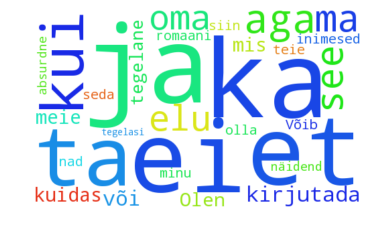

In [26]:
wordcloud = WordCloud(max_font_size = 160, max_words = 30, width = 500, height = 300, background_color = 'white').generate(text)
fig = plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Boonusülesanne.  (1p)

Vaadake Postimehe koostatud sõnapilve presidendi vabariigi aastapäeva kõne teksti pealt (pärit [siit](http://arvamus.postimees.ee/4027843/sonapilv-keda-voi-mida-mainis-kaljulaid-oma-kones-koige-enam)). Mõelge, mil moel saaks automaatse tekstitöötluse abil tulemust parandada. Genereerige uus ja parem sõnapilv (kõne teksti leiate failist *presidendi_tekst.txt*), mis oleks samuti Eesti kujuga. Näidis [siin.](https://github.com/amueller/word_cloud/blob/master/examples/masked.py)

![title](presidendipilv.png)